In this kernel, we will build CNN and train it over the cats and dogs images. I'll follow two approaches. 1st approach is where I dont use to_categorical() function on the labels. I just do Label Encoding. In 2nd approach, I apply to_categorical() on the labels. to_categorical() does the same thing what OneHotEncoder() does. 

**Please upvote the kernel if you like it ! Your upvotes will motivate me to write more. Thank you. **

**Importing Modules**

In [ ]:


import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline 
import warnings 
warnings.filterwarnings('ignore')
from os.path import join
import random as rn
from sklearn.metrics import accuracy_score,roc_auc_score
from keras.models import Sequential
from keras.layers import Flatten,Dense,Conv2D,Dropout,MaxPooling2D,Activation
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
import xgboost as xgb
from keras.utils import to_categorical



import os
print(os.listdir("../input"))



**Preparing Data**

In [ ]:
path='../input/train'
files=os.listdir('../input/train')
train_images_dogs=[file for file in files if 'dog' in file]
train_images_cats=[file for file in files if 'cat' in file]
X=[]
Y=[]

train=train_images_dogs[:1000]+train_images_cats[:1000]

width,height=150,150
def make_data(train):
    for file in train:
        img=cv2.imread(join(path,file))
        if img is not None:
            img=cv2.resize(img,(width,height))
            X.append(img)
            if 'dog' in file:
                Y.append(1)
            elif 'cat' in file:
                Y.append(0)
        else:
            continue
     
      
   


In [ ]:
make_data(train)

In [ ]:
X=np.array(X)
print(X.shape,len(Y))

**Watching some images**

In [ ]:
f,ax=plt.subplots(4,2,figsize=(10,10))
for i in range(4):
    for j in range(2):
        a=rn.randint(0,len(Y))
        ax[i,j].imshow(X[a])
        ax[i,j].set_title('{}'.format(Y[a]))

plt.tight_layout()
        

** Number of cats and dogs images**

We see that number of images of cats and dogs are almost equal if not equal

In [ ]:
y=pd.Series(Y)
y.value_counts().plot.bar()

**Building CNN**

Builing CNN with binary entries as labels rather than converting them to categorical. Due to this, when we predict the labels of test data, we get probability that the image belongs to '1' category, that is, dog

In [ ]:
train_X,val_X,train_y,val_y=train_test_split(X,Y,test_size=0.2,random_state=2)

In [ ]:
model1=Sequential()
model1.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(width,height,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(500,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1,activation='sigmoid'))


In [ ]:

model1.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

ImageDataGenerator is used for data augmentation. This allows us to have more training images than 2000. This also helps in avoiding overfit to some extent. In case of val_datagen, we only rescale the images. This is because we will be using that set not for training and only for validation. To avoid confusing the model and thus get lesser accuracy, we do not use functions like horizontal_flip and zoom in case of val_datagen

In [ ]:
epochs=20
batch_size=25
train_datagen=ImageDataGenerator(horizontal_flip=True,zoom_range=0.2,width_shift_range=0.2,
                                height_shift_range=0.2,rescale=1./255)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow(train_X,train_y,batch_size=batch_size)
val_generator=val_datagen.flow(val_X,val_y,batch_size=batch_size)

In [ ]:
result_data_aug=model1.fit_generator(train_generator,validation_data=val_generator,epochs=epochs,
                                    steps_per_epoch=len(train_y)//batch_size,validation_steps=len(val_y)//batch_size)

**Visualizing how loss and accuracy are varying across epochs**

In [ ]:
plt.style.use('ggplot')
plt.plot(result_data_aug.history['loss'],'green')
plt.plot(result_data_aug.history['val_loss'],'blue')
plt.xlabel('Number of epochs')
plt.legend(['train','test'])
plt.ylabel('Loss')


In [ ]:

plt.plot(result_data_aug.history['acc'],'green')
plt.plot(result_data_aug.history['val_acc'],'blue')
plt.xlabel('Number of epochs')
plt.legend(['train','test'])
plt.ylabel('Loss')

**Preparing test data and predicting their labels**

In [ ]:
test_files=os.listdir('../input/test')[:25]
path_test='../input/test'
test_img=[cv2.imread(join(path_test,file)) for file in test_files]
test_img=[cv2.resize(img,(width,height)) for img in test_img]
test=np.array(test_img)
                     

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./225)
test_generator=test_datagen.flow(test,batch_size=batch_size)
predict_prob=model1.predict_generator(test_generator,verbose=1,steps=1)

**Visualizing test images and probabilities that they are dogs given by our model.**

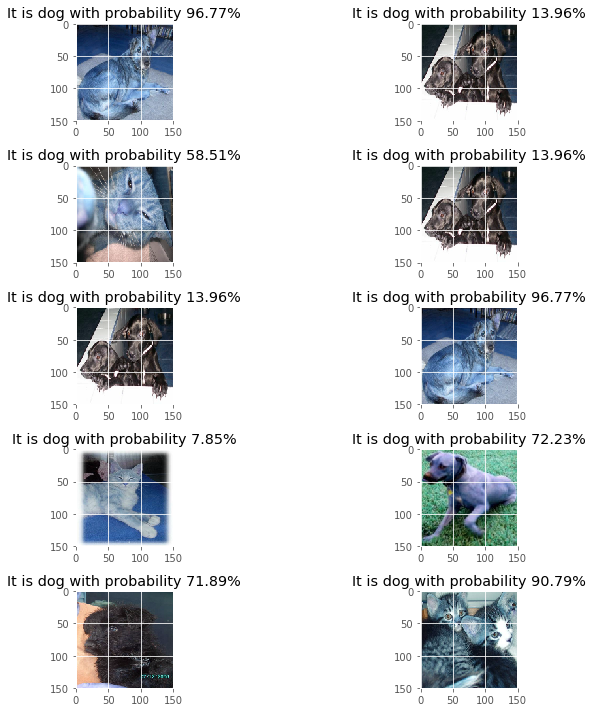

In [116]:
f,ax=plt.subplots(5,2,figsize=(10,10))
for i in range(5):
    for j in range(2):
        a=rn.randint(0,len(test_img)-1)
        ax[i,j].imshow(test[a])
        ax[i,j].set_title('It is dog with probability {:.2%}'.format(predict_prob[a][0]))
        
plt.tight_layout()

**New Approach**: Transforming the labels using to_categorical. to_categorical() does the same thing as what OneHotEncoder does.

In [ ]:

Z=np.array(Y)
Z=to_categorical(Z,2)

In [ ]:
X_train,X_val,z_train,z_val=train_test_split(X,Z,test_size=0.2,random_state=5)

In [ ]:
train_datagen1=ImageDataGenerator(horizontal_flip=True,zoom_range=0.2,width_shift_range=0.2,
                                height_shift_range=0.2)

train_datagen1.fit(X_train)
train_gen=train_datagen1.flow(X_train,z_train,batch_size=batch_size)


In [ ]:
model1=Sequential()
model1.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(width,height,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(500,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2,activation='softmax'))
sgd=SGD(lr=0.000001)
model1.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [ ]:
result_aug=model1.fit_generator(train_gen,validation_data=(X_val,z_val),epochs=epochs,
                               steps_per_epoch=X_train.shape[0]//batch_size)

In [ ]:
pred=model1.predict(test)
args=np.argmax(pred,axis=1)

In [ ]:
test_labels=[]
for i in range(len(args)):
    if args[i]==0:
        test_labels.append('cat')
    elif args[i]==1:
        test_labels.append('dog')
    

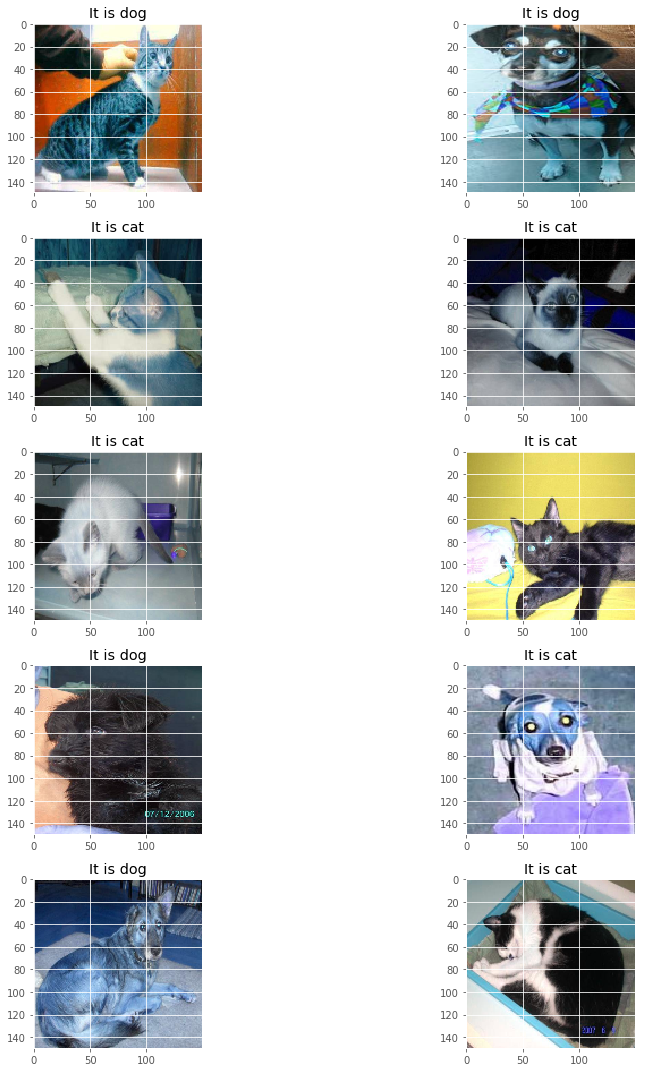

In [115]:
f,ax=plt.subplots(5,2,figsize=(15,15))
for i in range(5):
    for j in range(2):
        a=rn.randint(0,len(test_img)-1)
        ax[i,j].imshow(test[a])
        ax[i,j].set_title('It is {}'.format(test_labels[a]))
        
plt.tight_layout()

Certainly, by playing around with the number of hidden layers and neurons and using more number of images, we can increase the accuracy. Your suggestions are always welcomed ! Thank you